# Построение модели классификации для датасета Iris с помощью PyTorch

##Описание датасета

Iris Dataset был собран британским биологом и статистиком Рональдом Фишером в 1936 году. Этот набор включает 150 образцов цветка ириса, принадлежащих к **трем** различным видам: Iris setosa Iris versicolor и Iris virginica Для каждого образца измерены **четыре** характеристики:

Длина чашелистика (sepal length) в см.\
Ширина чашелистика (sepal width) в см.\
Длина лепестка (petal length) в см.\
Ширина лепестка (petal width) в см.

Задача классификации — включает в себя три четко определенных класса, один из которых линейно отделим, а два других — нет.\
Данный датасет не содержит пропущенных значений, что упрощает начальный анализ

##Код


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  ##
from torchvision import datasets
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt ##
import seaborn as sns  ##
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay ##
import numpy as np ##

In [ ]:
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
# Create DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [ ]:
# Альтернативный способ определения архитектуры:
model = nn.Sequential(
    nn.Linear(4, 20),  # Входной слой (4 столбца входной таблицы)
    nn.ReLU(),         # Функция активации ReLU
    nn.Linear(20, 10), # Первый скрытый слой (20 нейронов) -> Второй скрытый слой (10 нейронов)
    nn.ReLU(),         # Функция активации ReLU
    nn.Linear(10, 3)   # Второй скрытый слой (10 нейронов) -> Выходной слой (3 класса)
)

In [ ]:
# Перемещаем модель на GPU, если он доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=3, bias=True)
)

In [ ]:
# Определяем алгоритм оптимизации и функцию потерь
optimizer = optim.AdamW(model.parameters(), lr=0.006)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Функция для проведения одной эпохи обучения
def train_one_epoch(model, epoch, train_data_loader, test_data_loader, optimizer, criterion, device):
    model.train()   # переводим модель в режим обучения, включая dropout и batchnorm слои
    total_loss, correct, test_total_loss, test_correct = 0, 0, 0, 0
    progress_bar = tqdm(train_data_loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in progress_bar:  # перебор обучающей выборки на одной эпохе
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()   # обнуление градиентов, которые остались с предыдущего шага
        outputs = model(images) # пропускаем данные батча через модель
        loss = criterion(outputs, labels)   # вычисляем функцию потерь
        loss.backward() # обратное распространение ошибки
        optimizer.step()    # делаем шаг оптимизатора

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

        progress_bar.set_postfix_str(f"Loss: {total_loss / len(train_data_loader):.4f}, Accuracy: {correct / len(train_data_loader.dataset):.4f}")

    # Подсчет метрик и функции потерь на тестовой выборке после окончания эпохи
    model.eval() # переводим модель в режим инференса
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_total_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_data_loader)
    train_accuracy = correct / len(train_data_loader.dataset)
    test_loss = test_total_loss / len(test_data_loader)
    test_accuracy = test_correct / len(test_data_loader.dataset)
    return train_loss, train_accuracy, test_loss, test_accuracy



In [ ]:
epochs = 30
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(epochs):
    train_loss, accuracy, val_loss, val_accuracy = train_one_epoch(model, epoch, train_loader, test_loader, optimizer, criterion, device)
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(accuracy)
    history["val_accuracy"].append(val_accuracy)
    print(f"\nEpoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}")


Epoch 1/30, Loss: 1.0980, Accuracy: 0.3250, Test Loss: 1.0386, Test Accuracy: 0.3667



Epoch 2/30, Loss: 1.0459, Accuracy: 0.3250, Test Loss: 0.9699, Test Accuracy: 0.3667



Epoch 3/30, Loss: 0.9501, Accuracy: 0.5917, Test Loss: 0.8816, Test Accuracy: 0.7000



Epoch 4/30, Loss: 0.8378, Accuracy: 0.6583, Test Loss: 0.7506, Test Accuracy: 0.7000



Epoch 5/30, Loss: 0.7236, Accuracy: 0.6583, Test Loss: 0.6118, Test Accuracy: 0.7000



Epoch 6/30, Loss: 0.5857, Accuracy: 0.7083, Test Loss: 0.5058, Test Accuracy: 0.7667



Epoch 7/30, Loss: 0.4785, Accuracy: 0.7583, Test Loss: 0.4311, Test Accuracy: 0.8000



Epoch 8/30, Loss: 0.4266, Accuracy: 0.9333, Test Loss: 0.3817, Test Accuracy: 0.9667



Epoch 9/30, Loss: 0.3650, Accuracy: 0.9750, Test Loss: 0.3459, Test Accuracy: 0.8333



Epoch 10/30, Loss: 0.3350, Accuracy: 0.9000, Test Loss: 0.3094, Test Accuracy: 0.9000



Epoch 11/30, Loss: 0.2993, Accuracy: 0.9083, Test Loss: 0.2915, Test Accuracy: 0.8667



Epoch 12/30, Loss: 0.2798, Accuracy: 0.9667, Test Loss: 0.2397, Test Accuracy: 0.9667



Epoch 13/30, Loss: 0.2569, Accuracy: 0.9333, Test Loss: 0.2273, Test Accuracy: 0.9667



Epoch 14/30, Loss: 0.2218, Accuracy: 0.9500, Test Loss: 0.2029, Test Accuracy: 0.9667



Epoch 15/30, Loss: 0.1955, Accuracy: 0.9667, Test Loss: 0.1974, Test Accuracy: 0.9000



Epoch 16/30, Loss: 0.1707, Accuracy: 0.9583, Test Loss: 0.1827, Test Accuracy: 0.9667



Epoch 17/30, Loss: 0.1679, Accuracy: 0.9667, Test Loss: 0.1983, Test Accuracy: 0.8667



Epoch 18/30, Loss: 0.1549, Accuracy: 0.9667, Test Loss: 0.1532, Test Accuracy: 0.9667



Epoch 19/30, Loss: 0.1346, Accuracy: 0.9667, Test Loss: 0.1442, Test Accuracy: 0.9667



Epoch 20/30, Loss: 0.1319, Accuracy: 0.9750, Test Loss: 0.1548, Test Accuracy: 0.9333



Epoch 21/30, Loss: 0.1478, Accuracy: 0.9333, Test Loss: 0.1530, Test Accuracy: 0.9667



Epoch 22/30, Loss: 0.1257, Accuracy: 0.9750, Test Loss: 0.1652, Test Accuracy: 0.9000



Epoch 23/30, Loss: 0.1164, Accuracy: 0.9750, Test Loss: 0.1262, Test Accuracy: 0.9667



Epoch 24/30, Loss: 0.1164, Accuracy: 0.9750, Test Loss: 0.1679, Test Accuracy: 0.9000



Epoch 25/30, Loss: 0.1088, Accuracy: 0.9833, Test Loss: 0.1126, Test Accuracy: 0.9667



Epoch 26/30, Loss: 0.0909, Accuracy: 0.9833, Test Loss: 0.1277, Test Accuracy: 0.9333



Epoch 27/30, Loss: 0.0879, Accuracy: 0.9833, Test Loss: 0.1149, Test Accuracy: 0.9667



Epoch 28/30, Loss: 0.0996, Accuracy: 0.9750, Test Loss: 0.1034, Test Accuracy: 0.9667



Epoch 29/30, Loss: 0.1123, Accuracy: 0.9667, Test Loss: 0.1095, Test Accuracy: 0.9667



Epoch 30/30, Loss: 0.0853, Accuracy: 0.9750, Test Loss: 0.1013, Test Accuracy: 0.9667


Визуализация динамики точности и функции потерь:

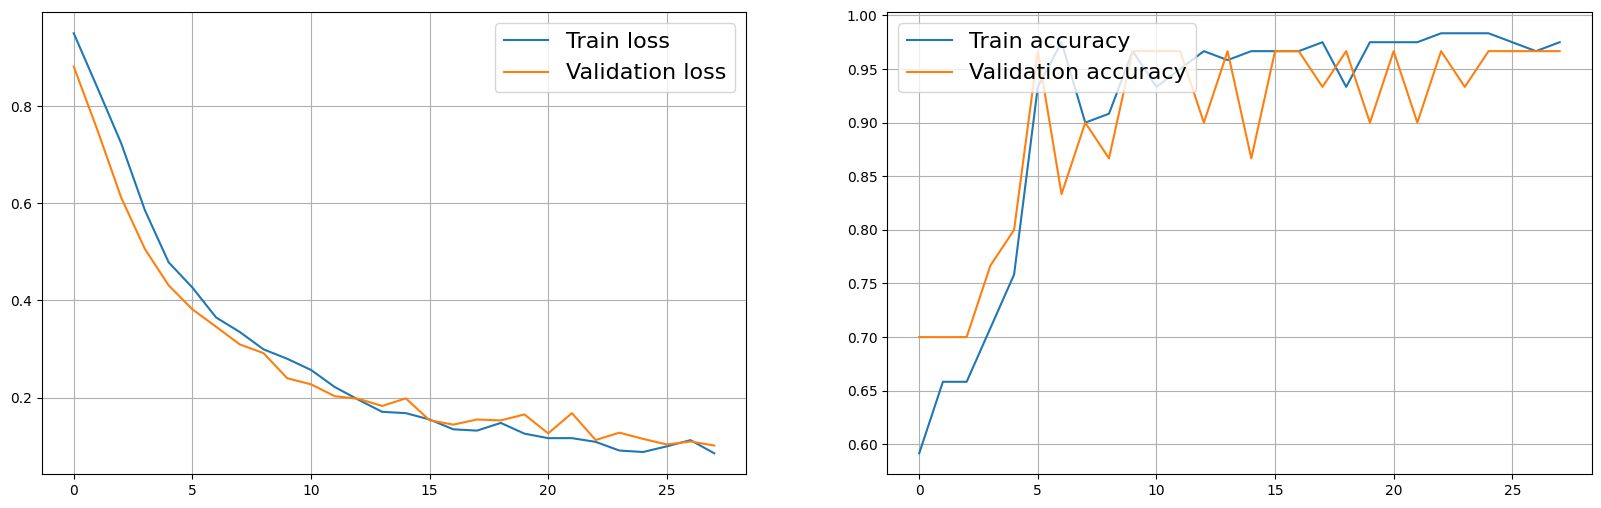

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(history['loss'][2:], label='Train loss')
axs[0].plot(history['val_loss'][2:], label='Validation loss')
axs[0].grid(True)
axs[0].legend(loc=1, prop={'size': 16})

axs[1].plot(history['accuracy'][2:], label='Train accuracy')
axs[1].plot(history['val_accuracy'][2:], label='Validation accuracy')
axs[1].grid(True)
axs[1].legend(loc=2, prop={'size': 16})

plt.show()

Расчет метрики точности и построение матрицы ошибок:

 Test Accuracy: 96.67%


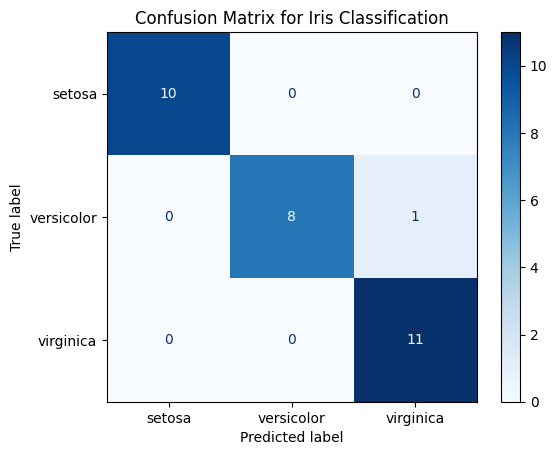

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = np.mean(y_true == y_pred) * 100
print(f" Test Accuracy: {accuracy:.2f}%")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Iris Classification')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted') * 100  # weighted учитывает дисбаланс классов
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f"Precision: {precision:.4f}%")
print(f"Recall:    {recall:.4f}%")
print(f"F1-score:  {f1:.4f}%")
print()

Precision: 96.9444%
Recall:    96.6667%
F1-score:  96.6411%

